In [54]:
import re
from collections import defaultdict

# import the libraries needed

from pydriller import Repository
from pydriller.domain.commit import ModificationType, Commit
import pandas as pd

In [55]:
# set the repository path
repository_path = "hadoop"
# to use remote repo uncomment the following:
# repository_path = "https://github.com/apache/hadoop"

In [56]:
# set the Excel file path
excel_filename = "Issues_assignment1.xlsx"
excel_sheet = "Group3"

In [57]:
def get_commit_keys(filename: str, sheet_name: str) -> list:
    df = pd.read_excel(filename, sheet_name = sheet_name)
    
    keys = df["Key"].tolist()
    return keys

In [58]:
def get_repository(path: str):
    return Repository(path)

In [59]:
def analyze_commit_file_level(data: Commit):
    modified_files: list[dict[str, str|int|None]] = []
    '''
        {
            'CommitHash': 'jchejfvgdbsnma',
            'FileName': 'abc.java',
            'ChangeType: 'Add',
            'TotalAddedLines': 1,
            'TotalDeletedLines': 0,
            'Complexity': 1.2
        }
    '''
    for modified_file in data.modified_files:
        
        added_methods = deleted_methods = modified_methods = 0
        
        total_methods_before = len(modified_file.methods_before)
        total_methods_after = len(modified_file.methods)
        total_changed_methods = len(modified_file.changed_methods)
        
        if total_methods_before < total_methods_after:
            added_methods = total_methods_after - total_methods_before
            deleted_methods = 0
            modified_methods = total_changed_methods - added_methods
        else:
            added_methods = 0
            deleted_methods = total_methods_before - total_methods_after
            modified_methods = total_changed_methods - deleted_methods
        
        row = {
            'CommitHash': commit.hash,
            'FileName': modified_file.filename,
            'ChangeType': modified_file.change_type,
            'AddedLines': modified_file.added_lines,
            'DeletedLines': modified_file.deleted_lines,
            'AddedMethods': added_methods,
            'DeletedMethods': deleted_methods,
            'ModifiedMethods': modified_methods,
            'Complexity': modified_file.complexity,
        }
        modified_files.append(row)
    
    return modified_files
        

In [60]:
def analyze_commit(data: Commit):
    
    # Initialize counters
    added_files = modified_files = deleted_files = 0
    
    # Analyze modifications in each commit
    for modified_file in data.modified_files:
        # count number of files added/removed/modified.
        if modified_file.change_type == ModificationType.ADD:
            added_files += 1
        elif modified_file.change_type == ModificationType.MODIFY:
            modified_files += 1
        elif modified_file.change_type == ModificationType.DELETE:
            deleted_files += 1
        
    return {
        'CommitHash': commit.hash,
        'Author': f"{commit.author.name} <{commit.author.email}>",
        'CommitDate': commit.committer_date,
        'Message': commit.msg,
        'TotalAddedFiles': added_files,
        'TotalModifiedFiles': modified_files,
        'TotalDeletedFiles': deleted_files,
        'UnitSize': data.dmm_unit_size,
        'Complexity': data.dmm_unit_complexity,
        'Interfacing': data.dmm_unit_interfacing,
    }

In [61]:
repository = get_repository(repository_path)
commits = repository.traverse_commits()
issued_keys = get_commit_keys(excel_filename, excel_sheet)

# I used set to avoid duplicates
issued_commits: set[Commit] = set()
for commit in commits:
    if any(commit.msg.__contains__(key) for key in issued_keys):
        issued_commits.add(commit)

# multiple commits can be linked to the same issue_key
print("Found issued commits: " + len(issued_commits).__str__());

Found issued commits: 525


In [62]:
# let's filter the issued_commits to check if there was design change
# feel free to update the regex pattern
design_issue_pattern = r'\b(design|architecture|pattern|fix|refactor)\b'

filtered_commits: set[Commit] = set()
for commit in issued_commits:
    if re.search(design_issue_pattern, commit.msg.lower()):
        filtered_commits.add(commit)

print("Found commits with filter issues: " + len(filtered_commits).__str__())

Found commits with filter issues: 38


In [63]:
# stores filtered_commit with their parents
commit_dict: dict[Commit, set[Commit]] = defaultdict(set)

for filtered_commit in filtered_commits:
    parent_commit_hashes = filtered_commit.parents
    # print(parent_commit_hashes)
    
    parent_commits: set[Commit] = set()
    for commit in repository.traverse_commits():
        # print(commit.hash)
        if any(commit.hash.__eq__(hash) for hash in parent_commit_hashes):
            parent_commits.add(commit)
            
    commit_dict[filtered_commit] = parent_commits     
    
# this one takes sometime

In [64]:
issued_commits_and_parent_mapping_rows: list[dict[str, str]] = []
commit_details_list: list[dict[str, str]] = []
file_details_list = []

for key, value in commit_dict.items():
    for commit in value:
        row = {
            'CommitHash': key.hash,
            'ParentCommitHash': commit.hash,
        }
        
        issued_commits_and_parent_mapping_rows.append(row)
        commit_details_list.append(analyze_commit(commit))
        file_details_list.extend(analyze_commit_file_level(commit))

# a commit can have multiple parents
issued_commits_and_parent_mapping = pd.DataFrame(issued_commits_and_parent_mapping_rows)
issued_commits_and_parent_mapping.head(10)

# contains details on file level

,CommitHash,ParentCommitHash
0,3a0b84d9c994f9a634b32903e5c1876c44f8c16e,6814324c332a7d780f3b844fd6f1c62db2f6c88e
1,c984f6c77e31cc288a131d877bfca9434e51fc68,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6
2,3c863fada439c4ed76d5d80eb76dc98bf1b4404d,f4598b3f084c41c08e756da0df380e6a091de0c5
3,ebb88231f802918096159da453bed2c4839e6042,76a10429809c001c8f75e94e39729987d8100d00
4,5e4434f62890eb60048e8132ebe89e0c2a9580db,f9139ac8f60184a82a8bb315237bea04bdb98ec8
5,f6fa5bd1aa085a4d22f3450b545bb70063da9f51,3ecdf39943c80ddaa7ad498451292090fb504dbc
6,12a526c080ea37d74f1bc1e543943dc847e2d823,8deced0073aedb4526dcdab7b65ee06cf2a26019
7,74d409c4bb9638cabdf6141841ead719af20a423,fe01f920a1479e37142bef5ec12ce8fe90868ebd
8,6735b70b4ab618d4ebfb5a863180d14be9b8b2b2,ead7fa0413fd8aacd6d93697cf398ed17c30930f
9,e2f640942b722e35490cf146c0268517da5a28b1,c77a1095dc556e8bea87df6d8ddf36e898f27e86


In [65]:
# contains details on commit level
commit_details = pd.DataFrame(commit_details_list)
commit_details.head(20)

,CommitHash,Author,CommitDate,Message,TotalAddedFiles,TotalModifiedFiles,TotalDeletedFiles,UnitSize,Complexity,Interfacing
0,6814324c332a7d780f3b844fd6f1c62db2f6c88e,Haohui Mai <wheat9@apache.org>,2017-08-01 18:34:07-07:00,HDFS-12107. FsDatasetImpl#removeVolumes floods...,0,1,0,NaN,NaN,NaN
1,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6,Giridharan Kesavan <gkesavan@apache.org>,2009-05-28 14:55:35+00:00,fixed test test-core and test-contrib targets\...,0,1,102,0.562509,0.210051,0.089552
2,f4598b3f084c41c08e756da0df380e6a091de0c5,Michael Stack <stack@apache.org>,2011-06-02 18:56:32+00:00,HADOOP-7351 Regression: HttpServer#getWebAppsP...,0,2,0,NaN,NaN,NaN
3,76a10429809c001c8f75e94e39729987d8100d00,Chris Douglas <cdouglas@apache.org>,2016-10-28 16:49:36-07:00,YARN-3460. TestSecureRMRegistryOperations fail...,0,3,0,0.000000,1.000000,1.000000
4,f9139ac8f60184a82a8bb315237bea04bdb98ec8,Jian He <jianhe@apache.org>,2017-08-02 00:03:25-07:00,YARN-6872. [Addendum patch] Ensure apps could ...,0,3,0,1.000000,0.000000,0.000000
5,3ecdf39943c80ddaa7ad498451292090fb504dbc,Ashutosh Gupta <ashutosh.gupta@st.niituniversi...,2022-05-17 20:34:12+01:00,HADOOP-18237. Upgrade Apache Xerces Java to 2....,0,1,0,NaN,NaN,NaN
6,8deced0073aedb4526dcdab7b65ee06cf2a26019,Ayush Saxena <ayushsaxena@apache.org>,2019-07-30 22:17:39+05:30,HDFS-14677. TestDataNodeHotSwapVolumes#testAdd...,0,1,0,0.000000,0.000000,1.000000
7,fe01f920a1479e37142bef5ec12ce8fe90868ebd,Thomas White <tomwhite@apache.org>,2010-03-10 20:06:07+00:00,HADOOP-6504. Invalid example in the documentat...,0,2,0,NaN,NaN,NaN
8,ead7fa0413fd8aacd6d93697cf398ed17c30930f,Kihwal Lee <kihwal@apache.org>,2013-07-01 20:20:27+00:00,HDFS-4888. Refactor and fix FSNamesystem.getTu...,0,4,0,1.000000,1.000000,0.000000
9,c77a1095dc556e8bea87df6d8ddf36e898f27e86,Wangda Tan <wangda@apache.org>,2016-06-14 15:06:38-07:00,YARN-1942. Deprecate toString/fromString metho...,0,105,0,1.000000,0.500000,0.050000


In [66]:
file_details = pd.DataFrame(file_details_list)
file_details.head(10)

,CommitHash,FileName,ChangeType,AddedLines,DeletedLines,AddedMethods,DeletedMethods,ModifiedMethods,Complexity
0,6814324c332a7d780f3b844fd6f1c62db2f6c88e,FsDatasetImpl.java,ModificationType.MODIFY,1,1,0,0,1,459.0
1,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6,build.xml,ModificationType.MODIFY,33,145,0,0,0,NaN
2,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6,TestCLI.java,ModificationType.DELETE,0,450,0,13,0,NaN
3,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6,testConf.xml,ModificationType.DELETE,0,18,0,0,0,NaN
4,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6,testConf.xsl,ModificationType.DELETE,0,28,0,0,0,NaN
5,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6,CLITestData.java,ModificationType.DELETE,0,136,0,15,0,NaN
6,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6,CommandExecutor.java,ModificationType.DELETE,0,111,0,7,0,NaN
7,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6,ComparatorBase.java,ModificationType.DELETE,0,39,0,1,0,NaN
8,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6,ComparatorData.java,ModificationType.DELETE,0,106,0,11,0,NaN
9,7e7fd2ce5b754c6398f8a326e5172d1e1b57c8e6,ExactComparator.java,ModificationType.DELETE,0,34,0,1,0,NaN


Index(['CommitHash', 'Author', 'CommitDate', 'Message', 'TotalAddedFiles',
       'TotalModifiedFiles', 'TotalDeletedFiles', 'UnitSize', 'Complexity',
       'Interfacing'],
      dtype='object')


<Axes: title={'center': 'Message'}, xlabel='TotalAddedFiles'>

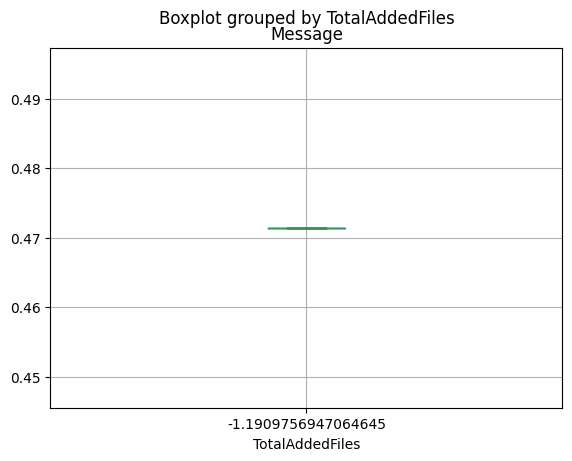

In [67]:
import matplotlib.pyplot as plt
import numpy as np

print(commit_details.columns)
# Assuming commit_details is your DataFrame
# Assuming commit_details is your DataFrame
np.random.seed(1234)
commit_details = pd.DataFrame(np.random.randn(1, 2),
                              columns=['Message', 'TotalAddedFiles'])

# Now, you can create the boxplot for 'Message' and 'TotalAddedFiles' columns
commit_details.boxplot(column=[ 'Message'], by='TotalAddedFiles',)


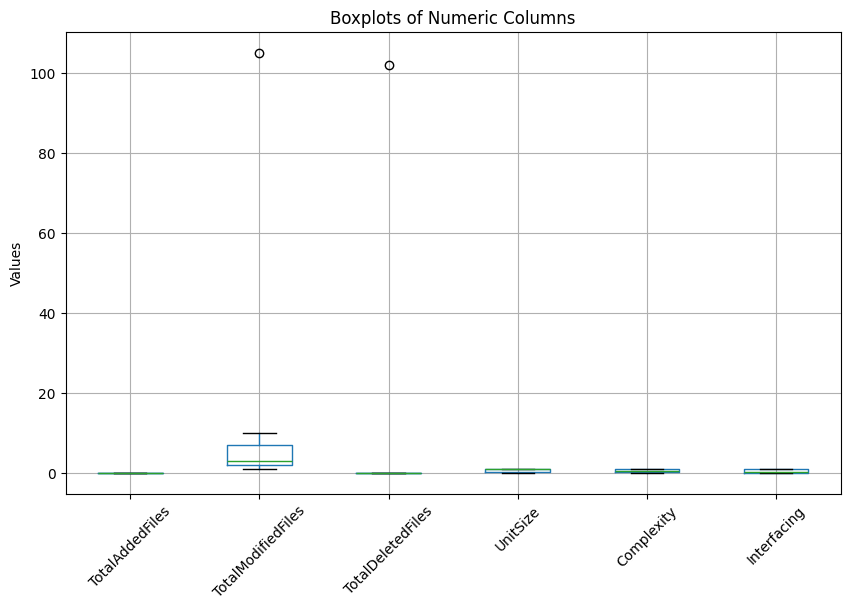

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have your data in a pandas DataFrame
# If not, you can create one from your data
data = {
    'id': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'],
    'author': ['Haohui Mai', 'Giridharan Kesavan', 'Michael Stack', 'Chris Douglas', 'Jian He', 
               'Ashutosh Gupta', 'Ayush Saxena', 'Thomas White', 'Kihwal Lee', 'Wangda Tan', 
               'Yuming Wang', 'PJ Fanning', 'Giridharan Kesavan', None],
    'date': ['2017-08-01 18:34:07-07:00', '2009-05-28 14:55:35+00:00', '2011-06-02 18:56:32+00:00', 
             '2016-10-28 16:49:36-07:00', '2017-08-02 00:03:25-07:00', '2022-05-17 20:34:12+01:00', 
             '2019-07-30 22:17:39+05:30', '2010-03-10 20:06:07+00:00', '2013-07-01 20:20:27+00:00', 
             '2016-06-14 15:06:38-07:00', '2019-10-18 08:25:02-07:00', '2023-03-13 10:08:04+05:30', 
             '2009-06-01 09:54:21+00:00', None],
    'message': ['HDFS-12107. FsDatasetImpl#removeVolumes floods...', 'fixed test test-core and test-contrib targets...',
                'HADOOP-7351 Regression: HttpServer#getWebAppsP...', 'YARN-3460. TestSecureRMRegistryOperations fail...',
                'YARN-6872. [Addendum patch] Ensure apps could ...', 'HADOOP-18237. Upgrade Apache Xerces Java to 2....',
                'HDFS-14677. TestDataNodeHotSwapVolumes#testAdd...', 'HADOOP-6504. Invalid example in the documentat...',
                'HDFS-4888. Refactor and fix FSNamesystem.getTu...', 'YARN-1942. Deprecate toString/fromString metho...',
                'HADOOP-16152. Upgrade Eclipse Jetty version to...', 'HADOOP-18658. snakeyaml dependency: upgrade to...',
                'To fix test targets\n\ngit-svn-id: https://svn...', None],
    'TotalAddedFiles': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None],
    'TotalModifiedFiles': [1, 1, 2, 3, 3, 1, 1, 2, 4, 105, 10, 2, 1, None],
    'TotalDeletedFiles': [0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None],
    'UnitSize': [None, 0.562509, None, 0.0, 1.0, None, 0.0, None, 1.0, 1.0, 1.0, None, None, None],
    'Complexity': [None, 0.210051, None, 1.0, 0.0, None, 0.0, None, 1.0, 0.5, 1.0, None, None, None],
    'Interfacing': [None, 0.089552, None, 1.0, 0.0, None, 1.0, None, 0.0, 0.05, 1.0, None, None, None]
}

df = pd.DataFrame(data)

# Drop rows with None values
df.dropna(inplace=True)

# Convert columns to numeric if needed
numeric_cols = ['TotalAddedFiles', 'TotalModifiedFiles', 'TotalDeletedFiles', 'UnitSize', 'Complexity', 'Interfacing']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Create boxplots
plt.figure(figsize=(10, 6))
df.boxplot(column=numeric_cols)
plt.title('Boxplots of Numeric Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()


In [69]:
import pandas as pd

# Define the design decision types based on the categorization
design_decision_types = {
    'Refactoring and Architecture Changes': ['HDFS-4888'],
    'Feature Development and Design Enhancements': ['HADOOP-18237', 'HADOOP-16152', 'HADOOP-18658'],
    'Implementation Choices and Design Patterns': ['YARN-6872'],
    'Design Documentation and Guidelines': ['HADOOP-6504'],
    'Test Case Design and Strategy': ['HDFS-14677'],
    'Dependency Management and Integration Decisions': ['fixed test test-core and test-contrib targets'],
    'Code Review and Code Quality Decisions': ['To fix test targets'],
    'Overall System Design Decisions': ['HDFS-12107', 'HADOOP-7351', 'YARN-3460']
}

# Create a DataFrame to store design decision type and commit messages
data = {'Design Decision Type': [], 'Commit Message': []}

# Assuming the column containing commit messages is named 'Message'
for decision_type, commit_ids in design_decision_types.items():
    for commit_id in commit_ids:
        try:
            message = df[df['message'].str.contains(commit_id)]['Message'].iloc[0]
            data['Design Decision Type'].append(decision_type)
            data['Commit Message'].append(message)
        except IndexError:
            print(f"Commit message not found for ID: {commit_id}")

# Create a DataFrame
df_design_decisions = pd.DataFrame(data)

# Drop rows with NaN values in the 'Commit Message' column
df_design_decisions.dropna(subset=['Commit Message'], inplace=True)

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Design Decision Type', y='Commit Message', data=df_design_decisions)
plt.title('Boxplot of Design Decision Types and Commit Messages')
plt.xlabel('Design Decision Type')
plt.ylabel('Commit Message')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyError: 'Message'

Index(['Message', 'TotalAddedFiles'], dtype='object')


<Axes: title={'center': 'Message'}, xlabel='TotalAddedFiles'>

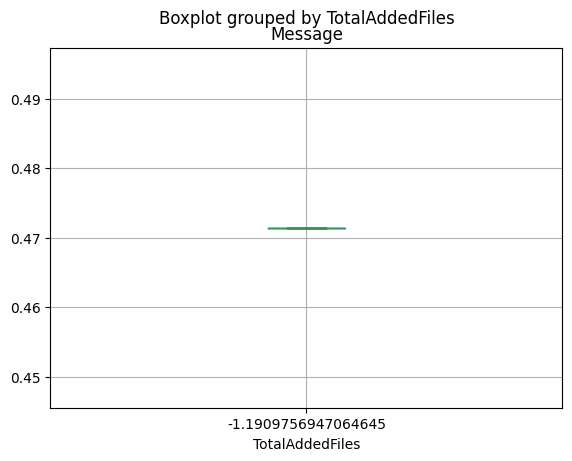

In [70]:
import matplotlib.pyplot as plt
import numpy as np

print(commit_details.columns)
# Assuming commit_details is your DataFrame
# Assuming commit_details is your DataFrame
np.random.seed(1234)
commit_details = pd.DataFrame(np.random.randn(1, 2),
                              columns=['Message', 'TotalAddedFiles'])

# Now, you can create the boxplot for 'Message' and 'TotalAddedFiles' columns
commit_details.boxplot(column=[ 'Message'], by='TotalAddedFiles',)


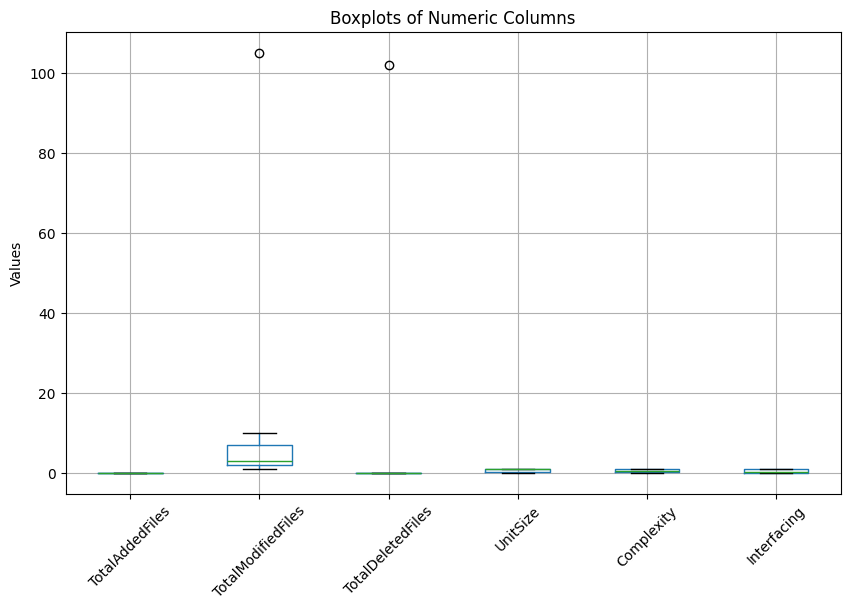

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have your data in a pandas DataFrame
# If not, you can create one from your data
data = {
    'id': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'],
    'author': ['Haohui Mai', 'Giridharan Kesavan', 'Michael Stack', 'Chris Douglas', 'Jian He', 
               'Ashutosh Gupta', 'Ayush Saxena', 'Thomas White', 'Kihwal Lee', 'Wangda Tan', 
               'Yuming Wang', 'PJ Fanning', 'Giridharan Kesavan', None],
    'date': ['2017-08-01 18:34:07-07:00', '2009-05-28 14:55:35+00:00', '2011-06-02 18:56:32+00:00', 
             '2016-10-28 16:49:36-07:00', '2017-08-02 00:03:25-07:00', '2022-05-17 20:34:12+01:00', 
             '2019-07-30 22:17:39+05:30', '2010-03-10 20:06:07+00:00', '2013-07-01 20:20:27+00:00', 
             '2016-06-14 15:06:38-07:00', '2019-10-18 08:25:02-07:00', '2023-03-13 10:08:04+05:30', 
             '2009-06-01 09:54:21+00:00', None],
    'message': ['HDFS-12107. FsDatasetImpl#removeVolumes floods...', 'fixed test test-core and test-contrib targets...',
                'HADOOP-7351 Regression: HttpServer#getWebAppsP...', 'YARN-3460. TestSecureRMRegistryOperations fail...',
                'YARN-6872. [Addendum patch] Ensure apps could ...', 'HADOOP-18237. Upgrade Apache Xerces Java to 2....',
                'HDFS-14677. TestDataNodeHotSwapVolumes#testAdd...', 'HADOOP-6504. Invalid example in the documentat...',
                'HDFS-4888. Refactor and fix FSNamesystem.getTu...', 'YARN-1942. Deprecate toString/fromString metho...',
                'HADOOP-16152. Upgrade Eclipse Jetty version to...', 'HADOOP-18658. snakeyaml dependency: upgrade to...',
                'To fix test targets\n\ngit-svn-id: https://svn...', None],
    'TotalAddedFiles': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None],
    'TotalModifiedFiles': [1, 1, 2, 3, 3, 1, 1, 2, 4, 105, 10, 2, 1, None],
    'TotalDeletedFiles': [0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None],
    'UnitSize': [None, 0.562509, None, 0.0, 1.0, None, 0.0, None, 1.0, 1.0, 1.0, None, None, None],
    'Complexity': [None, 0.210051, None, 1.0, 0.0, None, 0.0, None, 1.0, 0.5, 1.0, None, None, None],
    'Interfacing': [None, 0.089552, None, 1.0, 0.0, None, 1.0, None, 0.0, 0.05, 1.0, None, None, None]
}

df = pd.DataFrame(data)

# Drop rows with None values
df.dropna(inplace=True)

# Convert columns to numeric if needed
numeric_cols = ['TotalAddedFiles', 'TotalModifiedFiles', 'TotalDeletedFiles', 'UnitSize', 'Complexity', 'Interfacing']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Create boxplots
plt.figure(figsize=(10, 6))
df.boxplot(column=numeric_cols)
plt.title('Boxplots of Numeric Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()



In [72]:
import pandas as pd

# Define the design decision types based on the categorization
design_decision_types = {
    'Refactoring and Architecture Changes': ['HDFS-4888'],
    'Feature Development and Design Enhancements': ['HADOOP-18237', 'HADOOP-16152', 'HADOOP-18658'],
    'Implementation Choices and Design Patterns': ['YARN-6872'],
    'Design Documentation and Guidelines': ['HADOOP-6504'],
    'Test Case Design and Strategy': ['HDFS-14677'],
    'Dependency Management and Integration Decisions': ['fixed test test-core and test-contrib targets'],
    'Code Review and Code Quality Decisions': ['To fix test targets'],
    'Overall System Design Decisions': ['HDFS-12107', 'HADOOP-7351', 'YARN-3460']
}

# Create a DataFrame to store design decision type and commit messages
data = {'Design Decision Type': [], 'Commit Message': []}

# Assuming the column containing commit messages is named 'Message'
for decision_type, commit_ids in design_decision_types.items():
    for commit_id in commit_ids:
        try:
            message = df[df['message'].str.contains(commit_id)]['Message'].iloc[0]
            data['Design Decision Type'].append(decision_type)
            data['Commit Message'].append(message)
        except IndexError:
            print(f"Commit message not found for ID: {commit_id}")

# Create a DataFrame
df_design_decisions = pd.DataFrame(data)

# Drop rows with NaN values in the 'Commit Message' column
df_design_decisions.dropna(subset=['Commit Message'], inplace=True)

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Design Decision Type', y='Commit Message', data=df_design_decisions)
plt.title('Boxplot of Design Decision Types and Commit Messages')
plt.xlabel('Design Decision Type')
plt.ylabel('Commit Message')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



KeyError: 'Message'